In [2]:
import pandas as pd
from pandas import DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools
import os, sys

In [3]:
df0 = pd.read_csv("../testResults/test9.csv")
df0['time'] = pd.to_numeric(df0['time'])
df0['part.time'] = pd.to_numeric(df0['part.time'])
df0 = df0[(df0["time"] + df0["part.time"]) > 0]
df0

,cfg,thread no.,time,part.time
0,./assets/test/spider0.sumocfg,1,4258.84,18538.900
1,./assets/test/spider0.sumocfg,1,4288.02,760.856
2,./assets/test/spider0.sumocfg,1,4467.55,755.652
3,./assets/test/spider0.sumocfg,1,4364.56,758.575
4,./assets/test/spider0.sumocfg,1,4398.40,752.810
...,...,...,...,...
474,./assets/test/bologna-metropolitan-area/osm.su...,12,12630.80,745.532
475,./assets/test/bologna-metropolitan-area/osm.su...,12,12559.00,756.904
476,./assets/test/bologna-metropolitan-area/osm.su...,12,12539.50,746.237
477,./assets/test/bologna-metropolitan-area/osm.su...,12,12639.50,769.086


In [4]:
# df1 = df0.groupby(["cfg", "thread no."]).agg({
#     'time': 'mean',
#     'part.time': 'max'
# }).reset_index()
df1 = df0.copy()
df1["time"] = df1["time"].apply(lambda x: round(x / 1000, 2))
df1["cfg"] = df1["cfg"].apply(lambda x: x.replace("./assets/test/", ""))

df1

,cfg,thread no.,time,part.time
0,spider0.sumocfg,1,4.26,18538.900
1,spider0.sumocfg,1,4.29,760.856
2,spider0.sumocfg,1,4.47,755.652
3,spider0.sumocfg,1,4.36,758.575
4,spider0.sumocfg,1,4.40,752.810
...,...,...,...,...
474,bologna-metropolitan-area/osm.sumocfg,12,12.63,745.532
475,bologna-metropolitan-area/osm.sumocfg,12,12.56,756.904
476,bologna-metropolitan-area/osm.sumocfg,12,12.54,746.237
477,bologna-metropolitan-area/osm.sumocfg,12,12.64,769.086


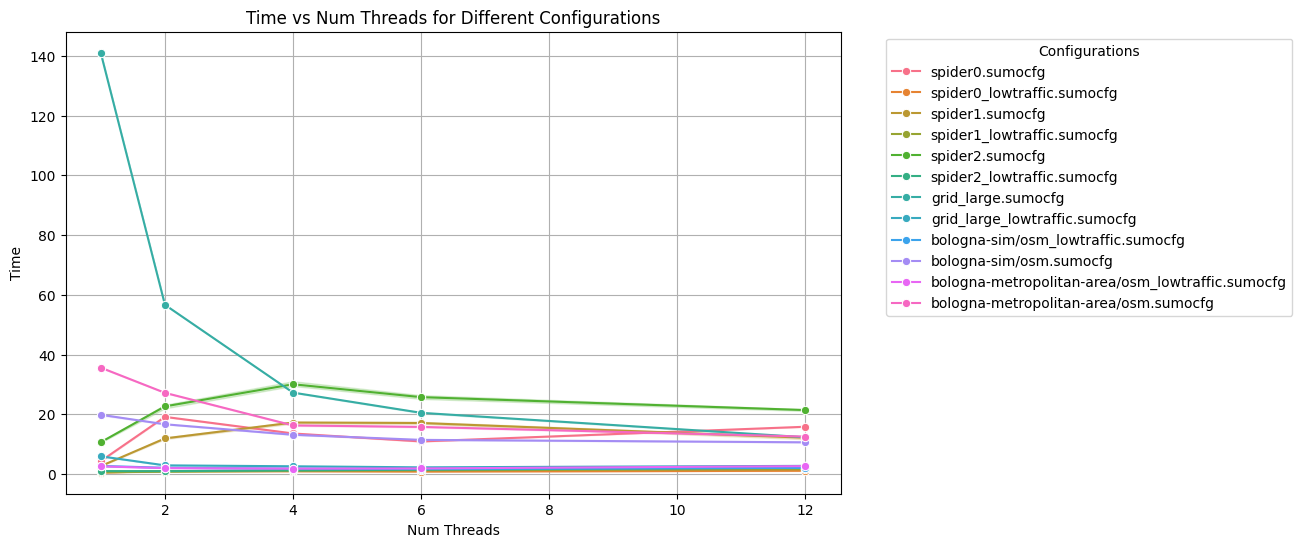

In [5]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df1, x='thread no.', y='time', hue='cfg', marker='o')
plt.title('Time vs Num Threads for Different Configurations')
plt.xlabel('Num Threads')
plt.ylabel('Time')
plt.legend(title='Configurations', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

In [6]:
import matplotlib.colors as mcolors
from scipy import stats

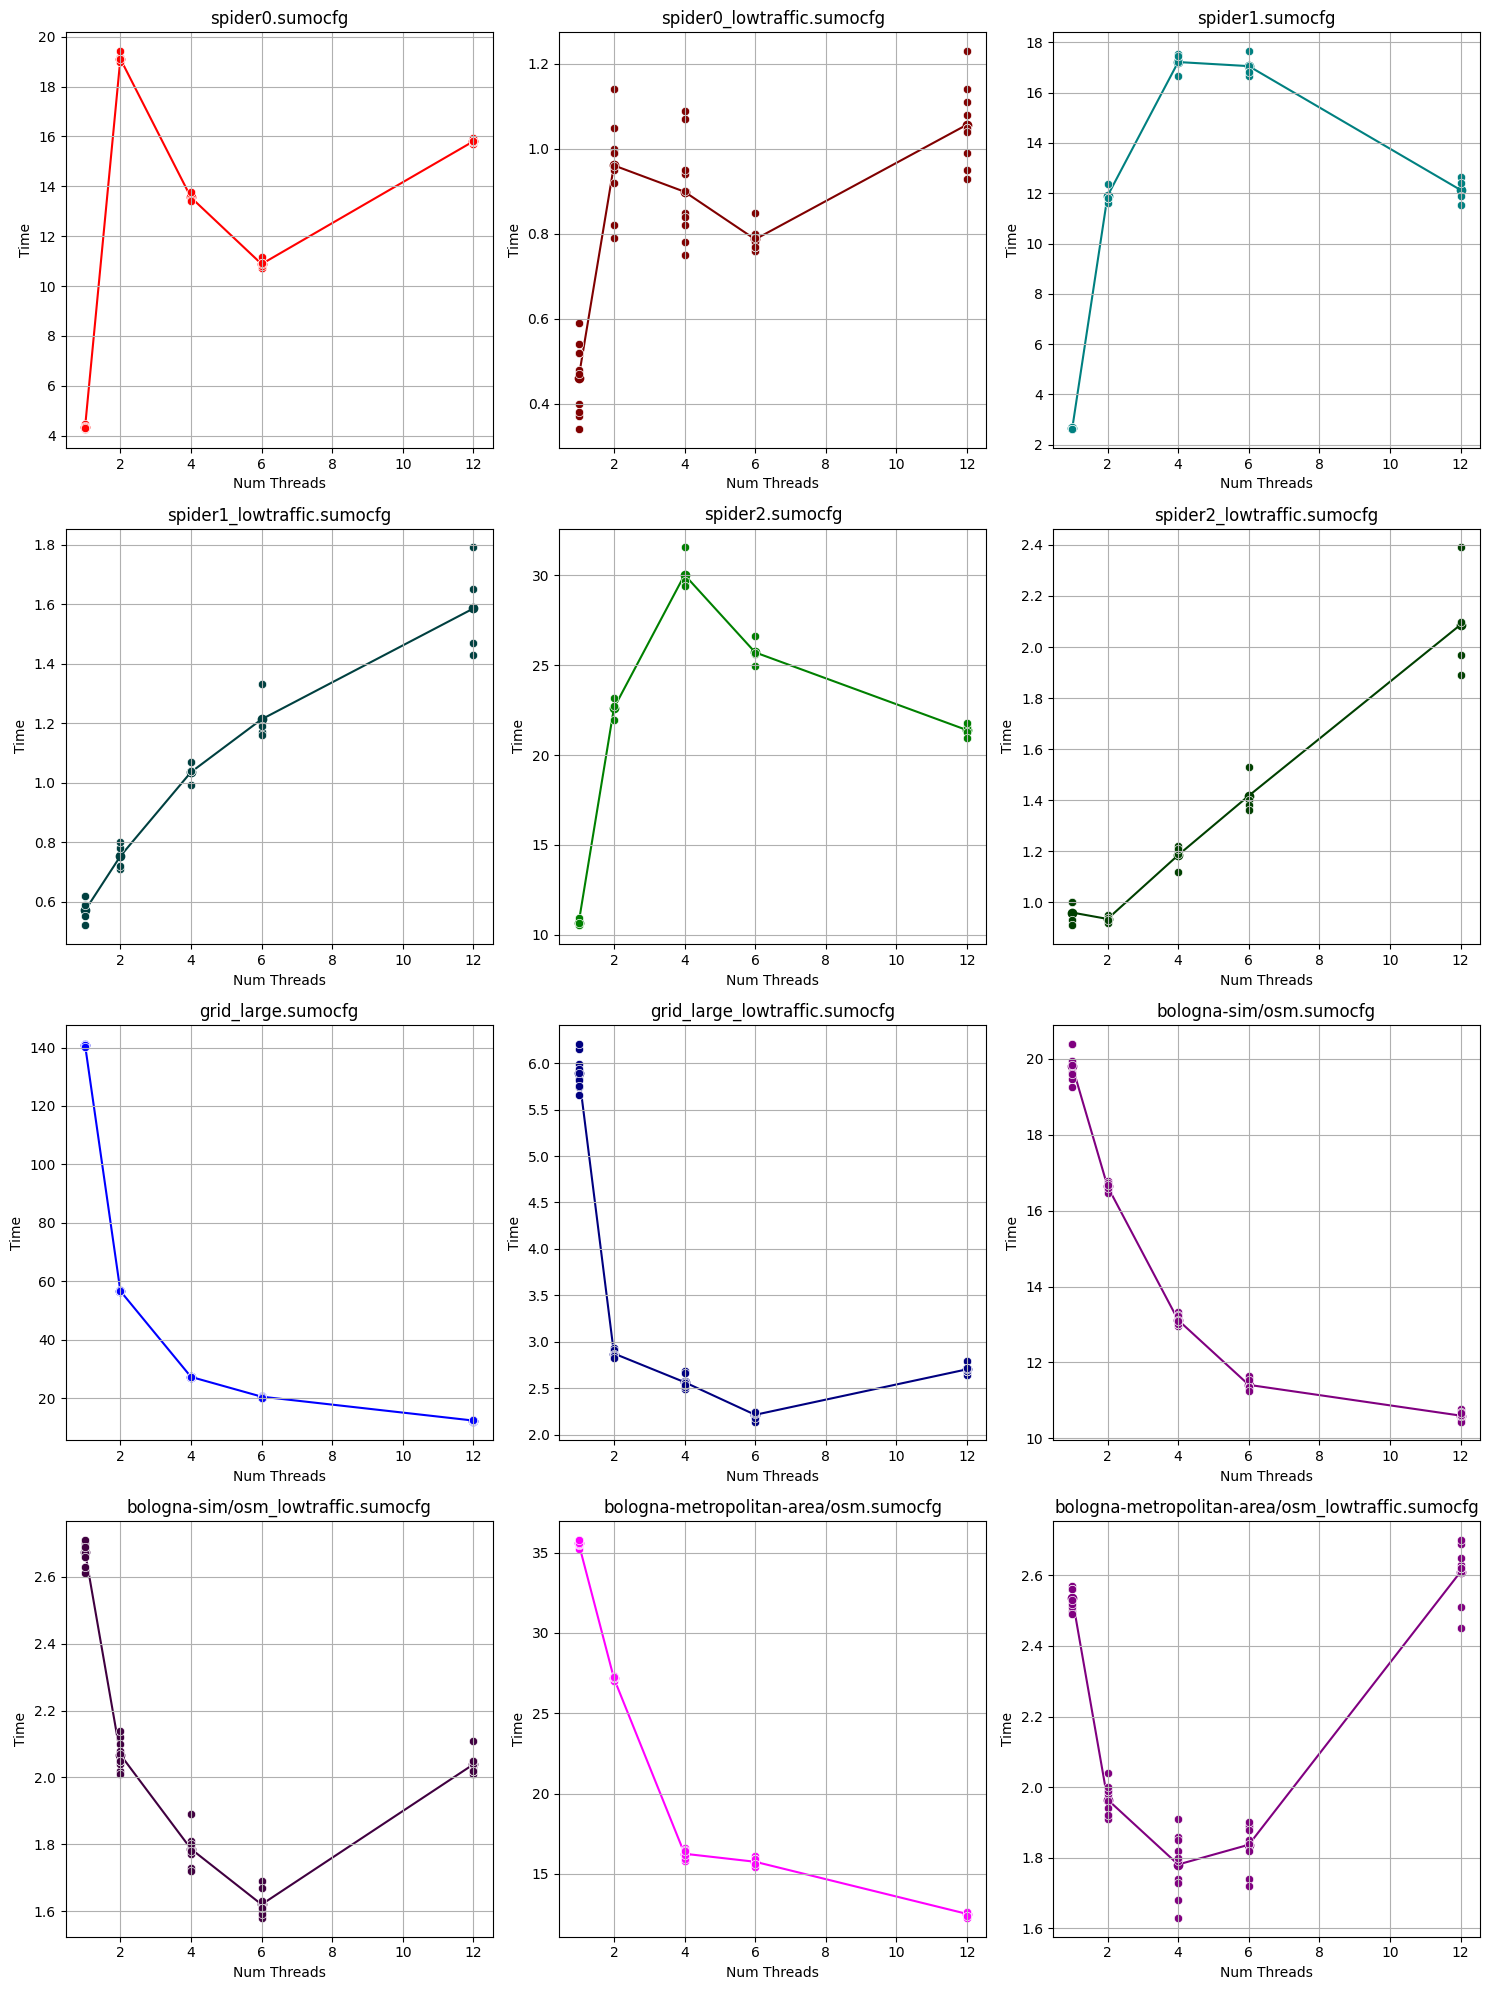

In [7]:
unique_configs = df1['cfg'].unique()
num_configs = len(unique_configs)
num_cols = 3  # Number of columns in the grid, you can adjust this

num_rows = int(np.ceil(num_configs / num_cols))
fig_all, axes_all = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

colors = ['red', 'teal', 'green', 'blue', 'purple', 'magenta', 'cyan', 'orange']
colors_dark = [mcolors.to_hex(tuple(c * 0.5 for c in mcolors.to_rgb(color))) for color in colors]
pair_colors = list(zip(colors, colors_dark))
colors_cycle = itertools.cycle(pair_colors)
    
def make_scatter(ax, cfg, color):
    data = df1[df1['cfg'] == cfg]
    sns.scatterplot(data=data, x='thread no.', y='time', ax=ax, color=color)
    ax.set_title(f'{cfg}')
    ax.set_xlabel('Num Threads')
    ax.set_ylabel('Time')
    ax.grid(True)
    
    # Calculate average y-values for unique x-values
    avg_y_values = data.groupby('thread no.')['time'].mean()
    x_values = avg_y_values.index
    y_values = avg_y_values.values
    
    # Plot a line connecting the average y-values for each x-value
    ax.plot(x_values, y_values, marker='o', linestyle='-', color=color, zorder=0)

    
def make_graph(ax, cfg, color):
    make_scatter(ax, cfg, color)
    # data = df1[df1['cfg'] == cfg]
    # ax.plot(data['thread no.'], data['time'], marker='o', color=color)
    # ax.set_title(f'{cfg}')
    # ax.set_xlabel('Num Threads')
    # ax.set_ylabel('Time')
    # ax.grid(True)

config_groups: dict[str, list] = {}
for cfg in unique_configs:
    lowt = "_lowtraffic" in cfg
    cfg_ = cfg.replace("_lowtraffic", "")
    if cfg_ in config_groups:
        if lowt:
            config_groups[cfg_].append(cfg)
        else:
            config_groups[cfg_].insert(0, cfg)
    else:
        config_groups[cfg_] = [cfg]

for i, (cfg_main, colors) in enumerate(zip(config_groups, colors_cycle)):
    cfgs = config_groups[cfg_main]
    # notebook visualization
    i2 = i*2
    for cfg, color in zip(cfgs, colors):
        row = i2 // num_cols
        col = i2 % num_cols
        data = df1[df1['cfg'] == cfg]
        ax = axes_all[row, col] if num_rows > 1 else axes_all[col]
        make_graph(ax, cfg, color)
        i2 += 1
        
    # Config files
    name = cfgs[0].replace(os.sep, "_")
    output_path = f'plots/{name}.png'

    fig, axes = plt.subplots(len(cfgs), 1, figsize=(10, 5 * len(cfgs)))

    for j, (cfg, color) in enumerate(zip(cfgs, colors)):
        data = df1[df1['cfg'] == cfg]
        ax = axes[j]
        make_graph(ax, cfg, color)

    # Save the figure
    plt.tight_layout()
    plt.savefig(output_path)
    plt.close()

# Hide any empty subplots
for i in range(len(unique_configs), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    if num_rows > 1:
        axes_all[row, col].axis('off')
    else:
        axes_all[col].axis('off')

plt.figure(1)
plt.tight_layout()
plt.show()

In [8]:
import os, sys
if 'SUMO_HOME' in os.environ:
    tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
    sys.path.append(os.path.join(tools))
    from sumolib.net import readNet
    from sumolib.net.edge import Edge
    from sumolib.net.node import Node
    import sumolib
else:
    print("please declare environment variable 'SUMO_HOME'")

import lxml.etree
from lxml.etree import _Element as Element, _ElementTree as ElementTree

In [9]:
cfg_props = []

for cfg in unique_configs:
    file = os.path.join("../assets/test/", cfg)
    
    cfg_tree: ElementTree = lxml.etree.parse(file)
    cfg_root: Element = cfg_tree.getroot()
    cfg_dir = os.path.dirname(file)
    
    net_file: str = os.path.join(cfg_dir, cfg_root.find("./input/net-file").attrib["value"])
    route_files: list[str] = [os.path.join(cfg_dir, x) for x in cfg_root.find("./input/route-files").attrib["value"].split(",")]
    
    net: sumolib.net.Net = readNet(net_file)
    nodes: list[Node] = net.getNodes()
    edges: list[Edge] = net.getEdges()
    
    num_vehicles = 0
    for routef in route_files:
        route_tree: ElementTree = lxml.etree.parse(routef)
        route_root: Element = route_tree.getroot()
        num_vehicles += len(route_root.findall("vehicle"))
        num_vehicles += len(route_root.findall("trip"))
    
    cfg_props.append({'cfg': cfg, 'nodes': len(nodes), 'edges': len(edges), 'vehicles': num_vehicles})
    
df2 = DataFrame(cfg_props).set_index("cfg")
df2.sort_index(inplace=True)
df2

,nodes,edges,vehicles
cfg,,,
bologna-metropolitan-area/osm.sumocfg,17255,36517,3546
bologna-metropolitan-area/osm_lowtraffic.sumocfg,17255,36517,345
bologna-sim/osm.sumocfg,473,852,2757
bologna-sim/osm_lowtraffic.sumocfg,473,852,343
grid_large.sumocfg,10000,39600,3600
grid_large_lowtraffic.sumocfg,10000,39600,360
spider0.sumocfg,15,50,3600
spider0_lowtraffic.sumocfg,15,50,360
spider1.sumocfg,120,464,3600


In [10]:
df2.to_latex(
    "../../elaborato/chap4_cfg_table.tex",
    escape="latex"
)